# Rover project
Roberto Lucchesi - 1744941

# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# custom modules
from graph import *
from AStar import *
from grid import *
from traj_gen import *
from rover import *
from utils import *


dataFolder = "data/"

## Constants of the problem
maxVel = 0.04; # [m/s] maximum velocity of the rover 
LAxis = 3; # [m] length of the rover wheel axis


In [2]:

### load data from csv file
# landmarks coordinates
P0 = (42.38*10**3, 11.59*10**3)
P1 = (33.07*10**3, 19.01*10**3)
P2 = (38.80*10**3, 25.00*10**3)
Xlm = np.loadtxt(dataFolder +"Xlm.csv")
Ylm = np.loadtxt(dataFolder +"Ylm.csv")
pos_lm = np.array([Xlm, Ylm]).T # landmark positions

# map and obstacle map
mars_map = np.loadtxt(dataFolder +"map.csv", delimiter=",")
obstacle_map = np.loadtxt(dataFolder +"obstacle.csv", delimiter=",")

sup_map = map_obstacle(mars_map, obstacle_map)

# Create mars_grid (45kmx30km, 10m resolution)
mars_grid = Grid(xlim = 45000, ylim = 30000, res = 10, 
            image = sup_map, obstacle = obstacle_map, 
            landmarks = pos_lm, corner = 'll') 


#plt.imshow(np.flipud(mars_grid.map), cmap='gray')
#plt.gca().invert_yaxis()
#plt.show()

# Task 1
- 1.1) Plot the trajectory of the rover in the map from P0 = (42.38, 11.59)km to P1 = (33.07,19.01)km
- 1.2) Plot the velocity profile of the rover
- 1.3) Plot the steering angle profile of the rover
- 1.4) Plot the rate of change of the steering angle profile of the rover

In [3]:
### TASK 1 ### --2.8s average runtime



## 1.1) Plot the trajectory of the rover in the map

# Create path with A*
path, gScore = AStar(mars_grid, P0, P1)
graph = Graph(path, mars_grid)

np_path = np.array(path)
arr_path = shorten_path(graph, 0,0)

# Get the trajectory of the rover





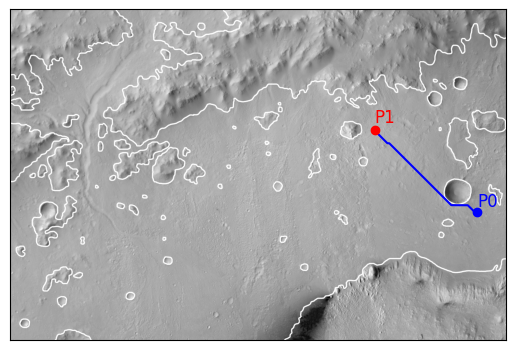

Cost:  12383.46463280844


In [4]:
## Plot TASK 1
# Plot path

plt.plot(np_path[:,0]/10, np_path[:,1]/10, 'b')

mars_grid.plot()

plt.plot(P0[0]/10, P0[1]/10, 'bo')
plt.text(P0[0]/10, P0[1]/10+50, 'P0', color='blue', fontsize=12)

plt.text(P1[0]/10, P1[1]/10+70, 'P1', color='red', fontsize=12)
plt.plot(P1[0]/10, P1[1]/10, 'ro')
plt.show()
print("Cost: ", gScore)

In [5]:
Curiosity_rover = Rover(maxVel, LAxis)

np_P0 = np.array([P0[0],P0[1], np.deg2rad(90)])
np_P1 = np.array([P1[0],P1[1], np.deg2rad(180)])

q, qd, t  = control_pose(Curiosity_rover, np_P0, np_P1, 1, 
                         k_rho=0.04, k_alpha=0.09, k_beta=-0.115)


cost_traj = cost_path(q[:,0:2])


theta_plot =  list_np_angle(q[:,2])
theta_dot_plot = np.unwrap(qd[:,2])
print("Theta_final: ",theta_plot[-1])
print("Cost: ", cost_traj)
print("Time of trajectory: ", t)
print("Time in sol: ", t/sol_in_secs)



Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.115)
Theta_final:  179.9999779726177
Cost:  13244.482120523948
Time of trajectory:  331147
Time in sol:  3.7301727883970917


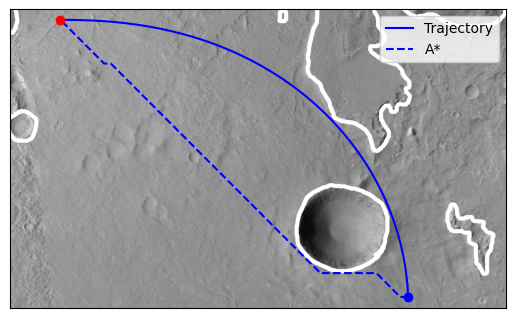

In [6]:


# Create submap around midpoint between P0 and P1
x_mid, y_mid = (P0[0]+P1[0])/2, (P0[1]+P1[1])/2

x_start, x_end = x_mid - 6000, x_mid + 20000
y_start, y_end = y_mid - 4000, y_mid + 4000

# Create submap
submap = mars_grid.get_submap(x_start, x_end, y_start, y_end)
submap.plot()


#plt.figure()
## Display the submatrix
#plt.imshow(np.flipud(submap), cmap='gray',  aspect='equal')
#plt.gca().invert_yaxis()



# Set the x and y ticks
plt.xticks([])
plt.yticks([])

plt.plot(q[:,0]/10 - x_start/10, q[:,1]/10-y_start/10, 'b')
plt.plot(np_path[:,0]/10 - x_start/10, np_path[:,1]/10-y_start/10, 'b', linestyle='--')
plt.plot(P0[0]/10 - x_start/10, P0[1]/10-y_start/10, 'bo')
plt.plot(P1[0]/10 - x_start/10, P1[1]/10-y_start/10, 'ro')
plt.legend(['Trajectory', 'A*'])


plt.show()




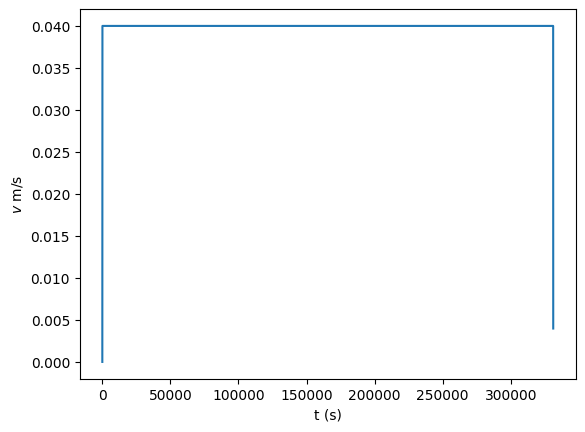

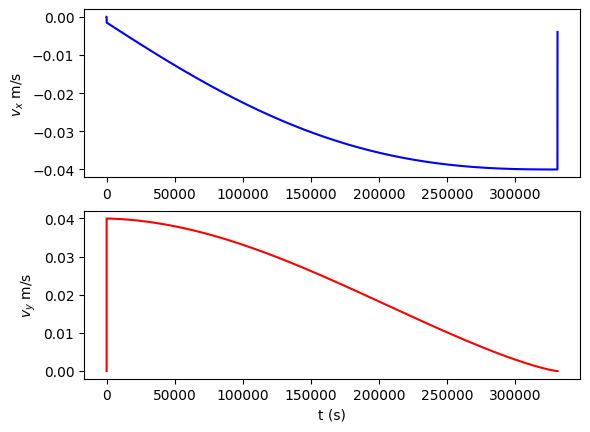

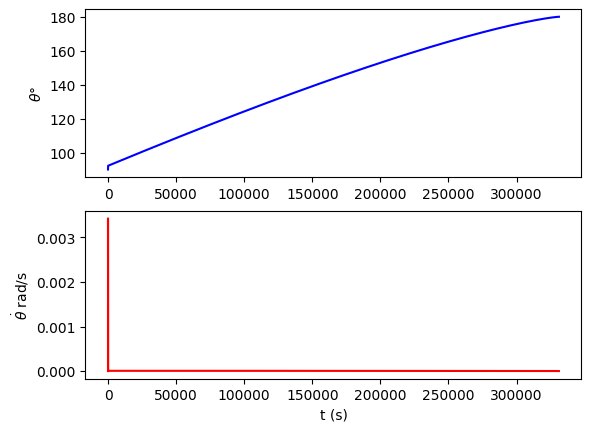

In [16]:
# plot velocity module
plt.figure()
plt.plot(np.sqrt(qd[:,0]**2 + qd[:,1]**2))
plt.ylabel(r'$v$' + " m/s")
plt.xlabel("t (s)")


# 1.2) Plot the velocity profile of the rover
plt.figure()
plt.subplot(2,1,1)
plt.ylabel(r'$v_x$' + " m/s")
plt.plot(qd[:,0], 'b-')
plt.subplot(2,1,2)
plt.ylabel(r'$v_y$' + " m/s")
plt.xlabel("t (s)")
plt.plot(qd[:,1], 'r-')

# 1.3) Plot the steering angle profile of the rover
plt.figure()
plt.subplot(2,1,1)
plt.ylabel(r'$\theta$' + "°")
plt.plot(theta_plot, 'b-')

# 1.4) Plot the rate of change of the steering angle profile of the rover
plt.subplot(2,1,2)
plt.ylabel(r'$\dot{\theta}$' + " rad/s")
plt.xlabel("t (s)")
plt.plot(theta_dot_plot, 'r-')
plt.show()





# Task 2

In [ ]:
### TASK 2 ### -- 3min average runtime
# Go from P1 to P2

P2 = (10.87*10**3, 25.67*10**3)
path2, gScore2 = AStar(mars_grid, P1, P2) # Run A* from P1 to P2



In [ ]:
## Plot TASK 2
# Plot path
path_coords2 = [(node[0], node[1]) for node in path2]
np_path2 = np.array(path_coords2)

plt.plot(np_path[:,0]/10, np_path[:,1]/10, 'b')
plt.plot(np_path2[:,0]/10, np_path2[:,1]/10, 'r')
    
mars_grid.plot()
plt.plot(P0[0]/10, P0[1]/10, 'bo')
plt.plot(P1[0]/10, P1[1]/10, 'ro')
plt.plot(P2[0]/10, P2[1]/10, 'go')
plt.show()
print("Cost: ", gScore2)


# Task 3

In [ ]:
### TASK 3 ### 

## Dead reckoning with odomoter only

r_traj = q[:,0:2] # trajectory of the rover

# Stdev on initial rover position
sigma_x = 6 # [m] standard deviation of the rover position
sigma_y = 6 # [m] standard deviation of the rover position
sigma_theta = np.deg2rad(1) # [rad] standard deviation of the rover orientation

# odometer noise 
sigma_d  = 4*10**(-3) # [m] standard deviation of the distance measurement
sigma_phi = np.deg2rad(0.05) # [rad] standard deviation of the angle measurement

P0 = np.eye(3)*[sigma_x**2, sigma_y**2, sigma_theta**2] # initial covariance matrix






